# Project

ChatGPT helped write the code required for using the `scikit-learn` and `tensorflow` implementations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [108]:
# Set up data sets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('MSFT.csv')
data = data.sort_values('Date')
#prices = data[['Open', 'Close']].values
prices = data[['Open', 'Low', 'High', 'Close']].values

num_features = len(prices[0]) - 1

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Split data
train_size = int(len(scaled_prices) * 0.7)
val_size = int(len(scaled_prices) * 0.1)

train_data = scaled_prices[:train_size]
val_data = scaled_prices[train_size:train_size + val_size]
test_data = scaled_prices[train_size + val_size:]
X_train, Y_train = train_data[:, :num_features].reshape(-1,num_features), train_data[:, num_features]
X_val, Y_val = val_data[:, :num_features].reshape(-1,num_features), val_data[:, num_features]
X_test, Y_test = test_data[:, :num_features].reshape(-1,num_features), test_data[:, num_features]

In [109]:
%%time
lr = LinearRegression()
lr.fit(X_train, Y_train)
predicted = lr.predict(X_test)
mean_squared_error(Y_test, predicted)

CPU times: user 5.37 ms, sys: 3.83 ms, total: 9.21 ms
Wall time: 7.54 ms


1.0247603305562238e-05

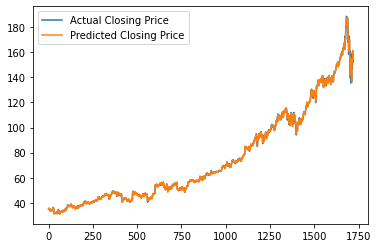

In [110]:
predicted = lr.predict(X_test)
zeros = np.zeros((predicted.shape[0], num_features))
data_to_inverse = np.concatenate([zeros, predicted.reshape(-1, 1)], axis=1)
predicted = scaler.inverse_transform(data_to_inverse)[:, num_features]
actual = scaler.inverse_transform(np.concatenate([np.zeros((Y_test.shape[0], num_features)), Y_test.reshape(-1, 1)], axis=1))[:, num_features]

import matplotlib.pyplot as plt
plt.plot(actual, label='Actual Closing Price')
plt.plot(predicted, label='Predicted Closing Price')
plt.legend()
plt.show()

https://pieriantraining.com/tensorflow-lstm-example-a-beginners-guide/

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0018 - val_loss: 1.2719e-05
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.2902e-05 - val_loss: 1.2602e-05
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.9118e-05 - val_loss: 1.2386e-05
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.0899e-05 - val_loss: 1.2063e-05
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.0645e-05 - val_loss: 2.5697e-05
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.1381e-05 - val_loss: 1.6681e-05
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.8198e-05 - val_loss: 9.6789e-06
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.8655e-05 - val_loss: 9.4326e-06
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.6920e-05 - val_loss: 2.3972e-05
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.6559e-05 - val_loss: 9.9529e-06
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.

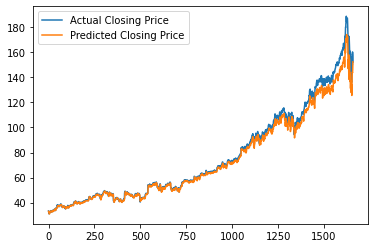

CPU times: user 7min 42s, sys: 38.3 s, total: 8min 21s
Wall time: 2min 52s


In [111]:
%%time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

train_data = scaled_prices[:train_size]
val_data = scaled_prices[train_size:train_size + val_size]
test_data = scaled_prices[train_size + val_size:]

def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :num_features])  # Using 'open' price as input
        y.append(data[i + sequence_length, num_features])    # Predict 'close' price
    return np.array(X), np.array(y)

sequence_length = 60  # Number of days in each sequence
X_train, Y_train = create_sequences(train_data, sequence_length)
X_val, Y_val = create_sequences(val_data, sequence_length)
X_test, Y_test = create_sequences(test_data, sequence_length)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], num_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_features))

model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, num_features)),
    Dense(1)  # Predicting a single value (close price)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=[early_stopping]
)

test_loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss (MSE): {test_loss}')

# Predict and inverse transform for interpretability
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(np.concatenate([np.zeros((predicted.shape[0], num_features)), predicted], axis=1))[:, num_features]
actual = scaler.inverse_transform(np.concatenate([np.zeros((Y_test.shape[0], num_features)), Y_test.reshape(-1, 1)], axis=1))[:, num_features]

# Optional: Plot results
import matplotlib.pyplot as plt
plt.plot(actual, label='Actual Closing Price')
plt.plot(predicted, label='Predicted Closing Price')
plt.legend()
plt.show()